In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.data import Dataset, Data, DataLoader
import pickle
import os



In [4]:
def load_data(save_dir):
    graphs = []
    for file in os.listdir(save_dir):
        if file.endswith(".pt"):
            graphs.append(torch.load(f'{save_dir}/{file}'))
    return graphs

save_dir = "./datanew/Data/saved_graphs_2/train"
train_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/val"
val_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/test"
test_pg_subgraph = load_data(save_dir)

C:\Users\Büşra\AppData\Local\Temp\ipykernel_19036\2775338884.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs.append(torch.load(f'{save_dir}/{file}'))


In [5]:
## To get the number of true gene and set true gene as data.y label
all_true_gene_ids = []

for patient in train_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

for patient in val_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)
    
for patient in test_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

## Get the unique true gene ids
unique_true_gene_ids = set(all_true_gene_ids)
print("the number of unique true gene ids is:",len(unique_true_gene_ids))

## Mapping all unique true gene ids to a index from 0 to the number of unique true gene ids
gene_id_mapping = {gene_id: idx for idx, gene_id in enumerate(unique_true_gene_ids)}
print(gene_id_mapping)

## Add the true gene ids back to the graph
for patient in train_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in val_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in test_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

print(train_pg_subgraph[0].true_gene_ids)
print(train_pg_subgraph[0].y)

print(val_pg_subgraph[0].true_gene_ids)
print(val_pg_subgraph[0].y)

print(test_pg_subgraph[0].true_gene_ids)
print(test_pg_subgraph[0].y)

the number of unique true gene ids is: 2405
{4: 0, 10: 1, 8204: 2, 8208: 3, 8210: 4, 18: 5, 22: 6, 23: 7, 29: 8, 30: 9, 8224: 10, 33: 11, 37: 12, 8231: 13, 41: 14, 42: 15, 8234: 16, 43: 17, 8246: 18, 61: 19, 67: 20, 8266: 21, 74: 22, 8268: 23, 78: 24, 80: 25, 83: 26, 85: 27, 87: 28, 88: 29, 8281: 30, 8283: 31, 8284: 32, 92: 33, 95: 34, 97: 35, 98: 36, 100: 37, 111: 38, 8305: 39, 8318: 40, 130: 41, 133: 42, 143: 43, 144: 44, 146: 45, 150: 46, 8345: 47, 154: 48, 162: 49, 163: 50, 57507: 51, 57506: 52, 169: 53, 8362: 54, 173: 55, 177: 56, 178: 57, 8371: 58, 8372: 59, 57521: 60, 8376: 61, 8378: 62, 187: 63, 8379: 64, 8388: 65, 8395: 66, 207: 67, 209: 68, 212: 69, 213: 70, 8405: 71, 8411: 72, 8416: 73, 8422: 74, 232: 75, 8428: 76, 238: 77, 8434: 78, 242: 79, 8437: 80, 246: 81, 8439: 82, 245: 83, 249: 84, 57595: 85, 8446: 86, 256: 87, 8454: 88, 8456: 89, 8458: 90, 8462: 91, 8464: 92, 57618: 93, 8466: 94, 276: 95, 279: 96, 8473: 97, 8477: 98, 288: 99, 8480: 100, 57632: 101, 291: 102, 8483: 10

In [7]:
## Preprocess the trainign data, extract only x, y, edge_index

from torch_geometric.data import Data

def preprocess_graph_data(dataset):
    processed_graphs = []
   
    for data in dataset:
        
        new_data = Data(
            edge_index=data.edge_index,
            y=data.y,
            x=data.x,
            original_ids = data.original_ids,
            edge_attr=data.edge_attr
        )
        processed_graphs.append(new_data)
    
    return processed_graphs

train_data = preprocess_graph_data(train_pg_subgraph)
val_data = preprocess_graph_data(val_pg_subgraph)
test_data = preprocess_graph_data(test_pg_subgraph)

In [81]:
## Define collate function for handling batched data
def optimized_collate_fn(batch):

    batch_size = len(batch)
    cumsum_nodes = 0
    
    # Adjust edge indices to account for the node offset in each batch
    adjusted_edge_indices = []
    for data in batch:
        edge_index = data.edge_index + cumsum_nodes
        adjusted_edge_indices.append(edge_index)
        cumsum_nodes += data.num_nodes

    # Concatenate with adjusted indices
    x = torch.cat([data.x for data in batch], dim=0)
    y = torch.cat([data.y for data in batch], dim=0)
    edge_index = torch.cat(adjusted_edge_indices, dim=1)
    edge_attr = torch.cat([data.edge_attr for data in batch], dim=0) if batch[0].edge_attr is not None else None
    batch_tensor = torch.cat([torch.full((data.num_nodes,), i, dtype=torch.long) for i, data in enumerate(batch)])
    
    ## Additional attributes
    original_ids = torch.cat([torch.tensor(data.original_ids, dtype=torch.long) if isinstance(data.original_ids, list) else data.original_ids for data in batch if data.original_ids is not None])
    
    return Data(
        x = x,
        y = y,
        edge_index=edge_index,
        edge_attr=edge_attr,
        batch=batch_tensor,
        original_ids=original_ids,
        batch_size=batch_size,
      
    )
## torch.dataloader doesn't consider custom data types
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


In [97]:
class NodeLevelModule(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, out_dim):
        super(NodeLevelModule, self).__init__()
        

        self.global_node_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
  
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, data):
        # Replace x with learned embeddings of original_ids
        x = self.global_node_embedding(data.original_ids.long().to(data.original_ids.device))  # Shape: [num_nodes, embedding_dim]
        
        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        return x  # Node embeddings


In [98]:
class PopulationLevelModule(nn.Module):
    def __init__(self, graph_dim, latent_dim):
        super(PopulationLevelModule, self).__init__()
        self.latent_project = nn.Linear(graph_dim, latent_dim)
        self.theta = nn.Parameter(torch.randn(1))  # Learnable threshold

    def forward(self, graph_representations):
        h_tilde = self.latent_project(graph_representations)
        similarity = torch.cdist(h_tilde, h_tilde, p=2)  # Euclidean distance
        adjacency_matrix = 1 / (1 + torch.exp(-self.theta * similarity))
        return adjacency_matrix  # Learned population-level graph



In [99]:
import torch.nn.functional as F
import torch.nn as nn

class GNNClassifier(nn.Module):
    def __init__(self, graph_dim, num_classes, dropout=0.3):
        super(GNNClassifier, self).__init__()

        self.fc1 = nn.Linear(graph_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout) 

    def forward(self, graph_repr, population_graph):
        x = F.relu(self.bn1(self.fc1(graph_repr)))  
        x = self.dropout(x)  

        x = F.relu(self.bn2(self.fc2(x)))  #
        x = self.dropout(x)  

        x = self.fc3(x)
        return x


In [100]:
def node_degree_distribution_loss(Ap, target_mean=7, target_std=2):
    degrees = Ap.sum(dim=1)  # Compute node degrees
    target_distribution = torch.normal(mean=target_mean, std=target_std, size=(Ap.shape[0],)).to(Ap.device)
    return F.mse_loss(degrees, target_distribution)



In [101]:
import matplotlib.pyplot as plt

def plot_adjacency_matrix(Ap, epoch):
    """ Function to plot adjacency matrix """
    Ap = Ap.detach().cpu().numpy()  # Convert to NumPy
    plt.figure(figsize=(6, 6))
    plt.imshow(Ap, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Adjacency Matrix - Epoch {epoch}")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.show()


In [102]:

def train_model(train_loader, val_loader, num_epochs=50, lr=0.001, alpha=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_embeddings = 105220  # Total number of unique node IDs
    embedding_dim = 64  # Adjust as needed
    hidden_dim = 128
    out_dim = 32

    f1 = NodeLevelModule(num_embeddings=num_embeddings, embedding_dim=embedding_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)

    # Adjust input features
    f2 = PopulationLevelModule(graph_dim=32, latent_dim=16).to(device)
    f3 = GNNClassifier(graph_dim=32, num_classes=2405).to(device)

    optimizer = optim.AdamW(
    list(f1.parameters()) + list(f2.parameters()) + list(f3.parameters()), 
    lr=lr, 
    weight_decay=1e-4  # 🆕 Adds L2 regularization
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True  # 🆕 Reduce LR when loss plateaus
     )

    criterion = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience, patience_counter = 5, 0 
    for epoch in range(num_epochs):
        f1.train()
        f2.train()
        f3.train()

        total_loss, total_correct, total_samples = 0, 0, 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            node_embeddings = f1(batch)  # Extract node-level embeddings
            graph_representations = global_mean_pool(node_embeddings, batch.batch)  # Aggregate per graph

            population_graph = f2(graph_representations)  # Learn population graph

            outputs = f3(graph_representations, population_graph)
            loss = criterion(outputs, batch.y) + alpha * node_degree_distribution_loss(population_graph)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(f1.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(f2.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(f3.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == batch.y).sum().item()
            total_samples += batch.y.size(0)

        train_acc = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")
              # 🔹 Plot adjacency matrix at the end of the epoch
        plot_adjacency_matrix(population_graph, epoch+1)
        scheduler.step(total_loss)

        # Validation
        val_loss, val_acc, val_f1 = evaluate_model(f1, f2, f3, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
        '''
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1  # Increase counter
            if patience_counter >= patience:
                print(" Early stopping triggered. Training stopped.")
                break
                '''

In [103]:
def evaluate_model(f1, f2, f3, data_loader, criterion, device):
    f1.eval()
    f2.eval()
    f3.eval()

    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            outputs = f3(graph_representations, population_graph)

            loss = criterion(outputs, batch.y)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            total_correct += (preds == batch.y).sum().item()
            total_samples += batch.y.size(0)

    acc = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss, acc, f1


In [104]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


print(f"Dataset Loaded: {len(train_data)} Train | {len(val_data)} Validation | {len(test_data)} Test")

Dataset Loaded: 36224 Train | 6400 Validation | 146 Test


C:\anaconda3\envs\graph\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 3759.3999, Accuracy: 0.0113


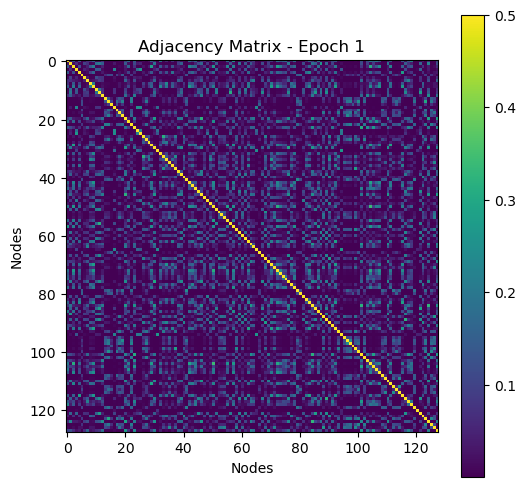

Validation Loss: 451.8205, Accuracy: 0.0103, F1-score: 0.0010
Epoch 2/30, Loss: 1957.6497, Accuracy: 0.0352


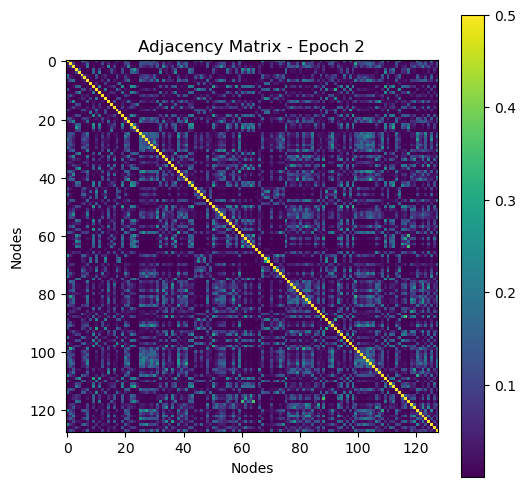

Validation Loss: 505.2632, Accuracy: 0.0208, F1-score: 0.0040
Epoch 3/30, Loss: 1690.6899, Accuracy: 0.0735


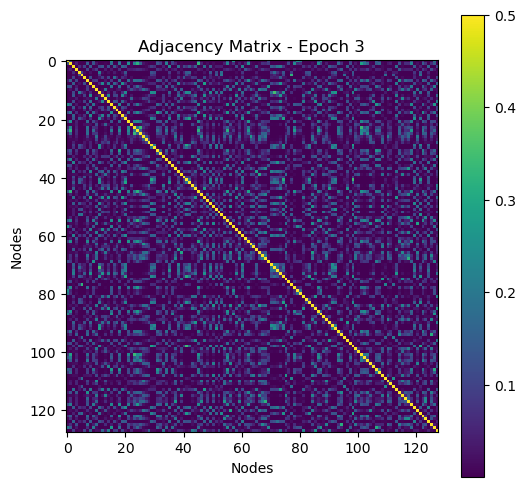

Validation Loss: 535.3329, Accuracy: 0.0283, F1-score: 0.0076
Epoch 4/30, Loss: 1476.6177, Accuracy: 0.1177


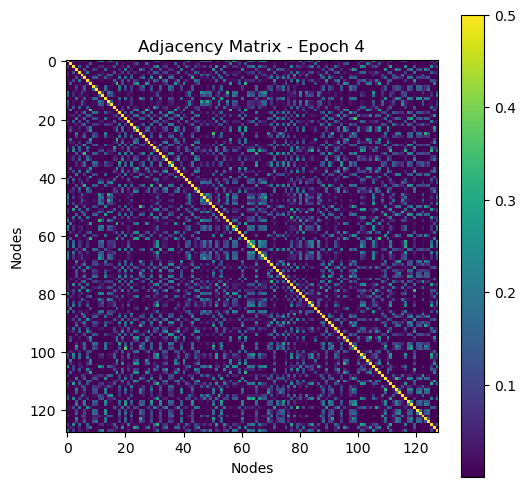

Validation Loss: 570.9737, Accuracy: 0.0361, F1-score: 0.0082
Epoch 5/30, Loss: 1307.6876, Accuracy: 0.1730


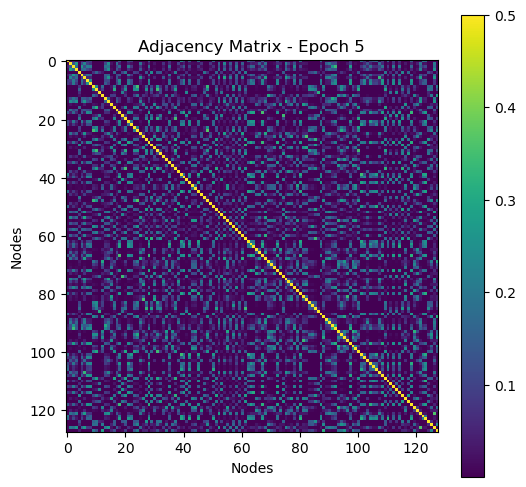

Validation Loss: 591.8543, Accuracy: 0.0416, F1-score: 0.0101
Epoch 6/30, Loss: 1179.7819, Accuracy: 0.2206


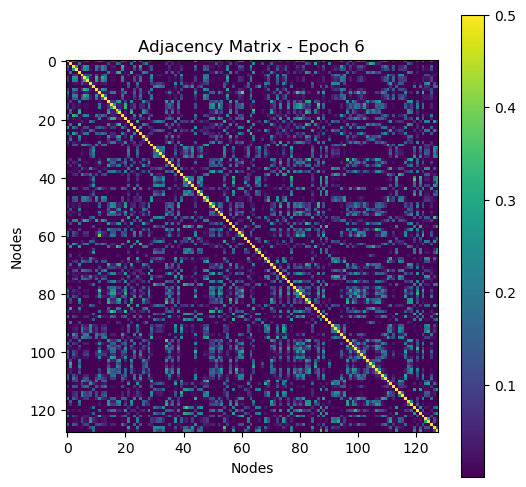

Validation Loss: 628.5145, Accuracy: 0.0439, F1-score: 0.0101
Epoch 7/30, Loss: 1115.0151, Accuracy: 0.2653


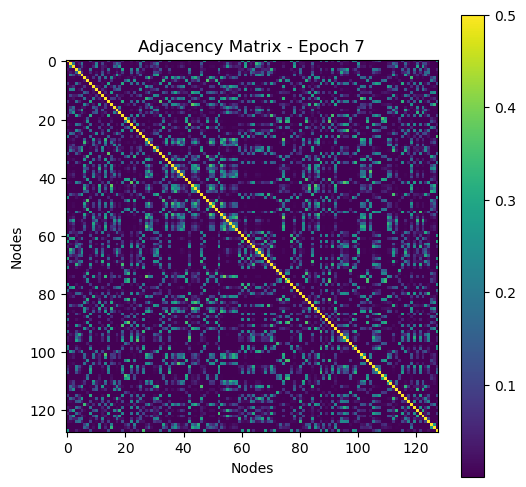

Validation Loss: 653.3394, Accuracy: 0.0488, F1-score: 0.0108
Epoch 8/30, Loss: 1115.0578, Accuracy: 0.3007


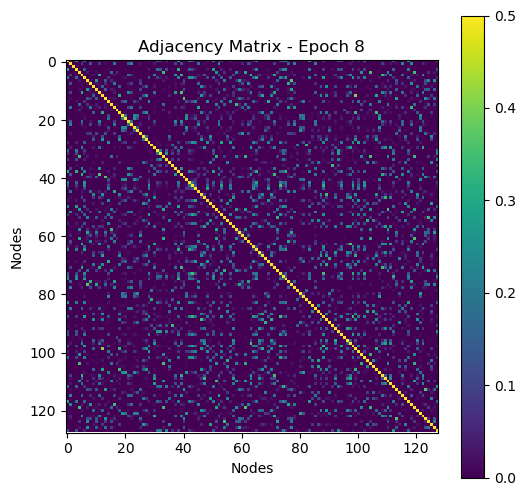

Validation Loss: 640.8606, Accuracy: 0.0517, F1-score: 0.0114
Epoch 9/30, Loss: 18624.1427, Accuracy: 0.2655


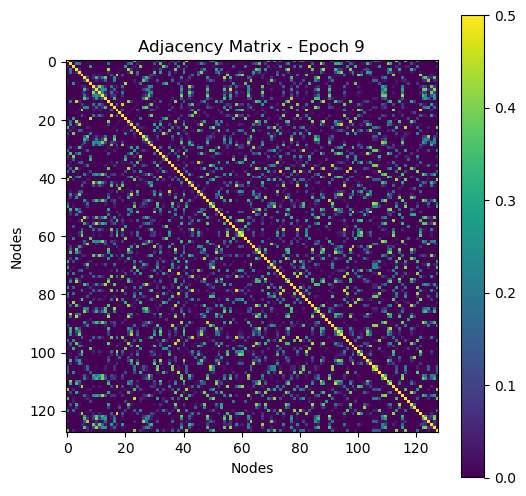

Validation Loss: 610.9657, Accuracy: 0.0423, F1-score: 0.0103
Epoch 10/30, Loss: 22879.4784, Accuracy: 0.2882


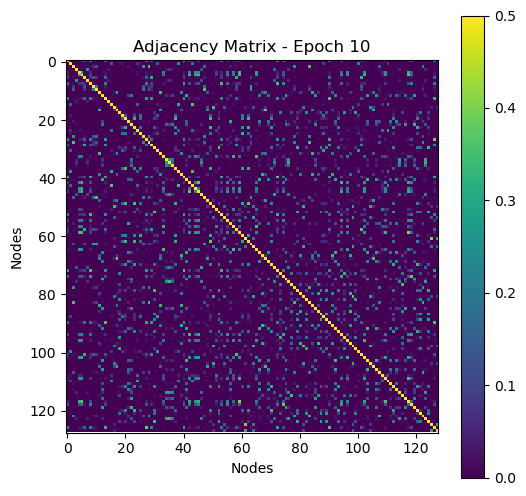

Validation Loss: 632.3372, Accuracy: 0.0467, F1-score: 0.0101
Epoch 11/30, Loss: nan, Accuracy: 0.2659


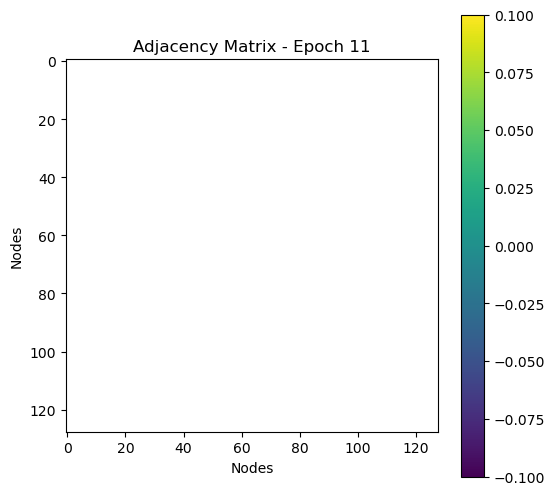

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 12/30, Loss: nan, Accuracy: 0.0004


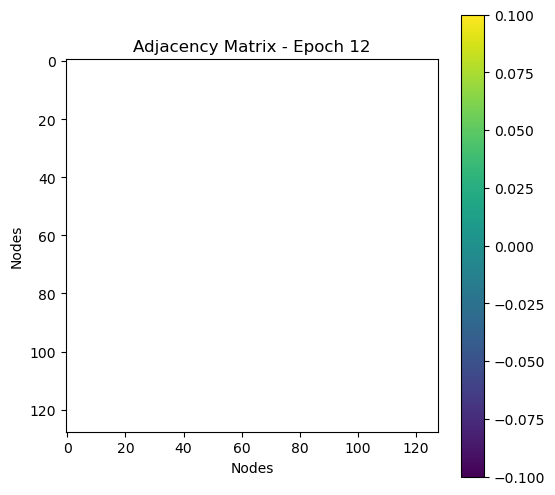

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000


KeyboardInterrupt: 

In [106]:
train_model(train_loader, val_loader, num_epochs=30, lr=0.01, alpha=0.1)

In [107]:
def test_model(f1, f2, f3, test_loader, criterion, device):
    f1.eval()
    f2.eval()
    f3.eval()
    
    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            outputs = f3(graph_representations, population_graph)
            
            loss = criterion(outputs, batch.y)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            total_correct += (preds == batch.y).sum().item()
            total_samples += batch.y.size(0)

    acc = total_correct / total_samples
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"\n🔥 Test Results: Loss={total_loss:.4f} | Accuracy={acc:.4f} | F1-score={f1_macro:.4f}\n")
    
    return total_loss, acc, f1_macro


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


f1 = NodeLevelModule(num_embeddings=105220, embedding_dim=64, hidden_dim=128, out_dim=32).to(device)
# Load trained models
f2 = PopulationLevelModule(graph_dim=32, latent_dim=16).to(device)
f3 = GNNClassifier(graph_dim=32, num_classes=2405).to(device)

# Load best weights if saved (Optional)
# f1.load_state_dict(torch.load("f1_best.pth"))
# f2.load_state_dict(torch.load("f2_best.pth"))
# f3.load_state_dict(torch.load("f3_best.pth"))

criterion = nn.CrossEntropyLoss()

# Run testing
test_model(f1, f2, f3, test_loader, criterion, device)


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# Save
torch.save(f1.state_dict(), "f1_best.pth")
torch.save(f2.state_dict(), "f2_best.pth")
torch.save(f3.state_dict(), "f3_best.pth")

# Load later
f1.load_state_dict(torch.load("f1_best.pth"))
f2.load_state_dict(torch.load("f2_best.pth"))
f3.load_state_dict(torch.load("f3_best.pth"))
